<a href="https://colab.research.google.com/github/pauchai/SubPlayer/blob/master/lessons/%D0%9F%D1%80%D0%BE%D0%B4%D0%B2%D0%B8%D0%BD%D1%83%D1%82%D1%8B%D0%B9_%D0%B1%D0%BB%D0%BE%D0%BA_%7C_%D0%93%D0%B5%D0%BD%D0%B5%D1%82%D0%B8%D1%87%D0%B5%D1%81%D0%BA%D0%B8%D0%B5_%D0%B0%D0%BB%D0%B3%D0%BE%D1%80%D0%B8%D1%82%D0%BC%D1%8B_%D0%9F%D0%BE%D0%B4%D0%B1%D0%BE%D1%80_%D0%B3%D0%B8%D0%BF%D0%B5%D1%80%D0%BF%D0%B0%D1%80%D0%B0%D0%BC%D0%B5%D1%82%D1%80%D0%BE%D0%B2_%D0%BD%D0%B5%D0%B9%D1%80%D0%BE%D0%BD%D0%BD%D0%BE%D0%B9_%D1%81%D0%B5%D1%82%D0%B8_%7C_%D0%94%D0%97_Light_(%D0%A0%D0%B0%D0%B7%D0%B1%D0%BE%D1%80)_%7C_%D0%A3%D0%98%D0%98.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Задание LIGHT**


Подберите архитектуру нейронной сети с помощью генетического алгоритма для задачи предсказания тренда акций Сбербанка (подготовку данных можно взять из занятия "временные ряды", можно сделать самостоятельно)

In [ ]:
import gdown

# Загрузка датасетов из облака
gdown.download('https://storage.yandexcloud.net/aiueducation/Content/base/l11/SBER_MIN60.txt', None, quiet=True)

'SBER_MIN60.txt'

Подключаем необходимый набор библиотек:

In [ ]:
# Работа с массивами
import numpy as np

# Работа с таблицами
import pandas as pd

# Кодирование категориальных данных в формате OHE
from tensorflow.keras.utils import to_categorical

# Классы-конструкторы моделей нейронных сетей
from tensorflow.keras.models import Sequential, Model

# Основные слои
from tensorflow.keras.layers import concatenate, Input, Dense, Dropout, BatchNormalization, Flatten, Conv1D, Conv2D, LSTM, GlobalMaxPooling1D, MaxPooling1D, RepeatVector, GlobalAveragePooling1D

# Оптимизаторы
from tensorflow.keras.optimizers import Adam

# Нормировщики
from sklearn.preprocessing import StandardScaler, MinMaxScaler 

# Матрица ошибок классификатора
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Отрисовка графиков
import matplotlib.pyplot as plt

# Отрисовка графики в ячейке colab
%matplotlib inline

import random

import time

# Отключение предупреждений
import warnings
warnings.filterwarnings('ignore')

In [ ]:
# Назначение размера и стиля графиков по умолчанию
from pylab import rcParams
plt.style.use('ggplot')
rcParams['figure.figsize'] = (14, 7)

In [ ]:
# Чтение данных в таблицу Pandas и назначение имен столбцов
data = pd.read_csv('SBER_MIN60.txt', sep="\t", names=['Datetime', 'Open', 'High', 'Low', 'Close'])

# Настройка имен столбцов
COL_DATE = 'Datetime'
COL_CLOSE = 'Close'

# Настройка временного интервала для ограничения данных
TIME_RANGE = ('2010-09-01 10:00:00.000', '2018-12-31 23:59:00.000')

In [ ]:
# Преобразование столбца даты в индекс таблицы и удаление ненужного столбца даты
data.index = pd.to_datetime(data[COL_DATE])
data.drop(columns=COL_DATE, inplace=True)

# Отбор данных по заданному временному интервалу
mask = (data.index >= TIME_RANGE[0]) & (data.index <= TIME_RANGE[1])
data = data[mask]

Отобразим датафрейм

In [ ]:
data.head()

,Open,High,Low,Close
Datetime,,,,
2010-09-01 10:00:00,78.55,78.67,77.94,78.04
2010-09-01 11:00:00,78.04,78.10,77.60,78.00
2010-09-01 12:00:00,78.00,78.88,77.98,78.88
2010-09-01 13:00:00,78.89,79.19,78.80,78.85
2010-09-01 14:00:00,78.85,78.99,78.61,78.86


на графике:

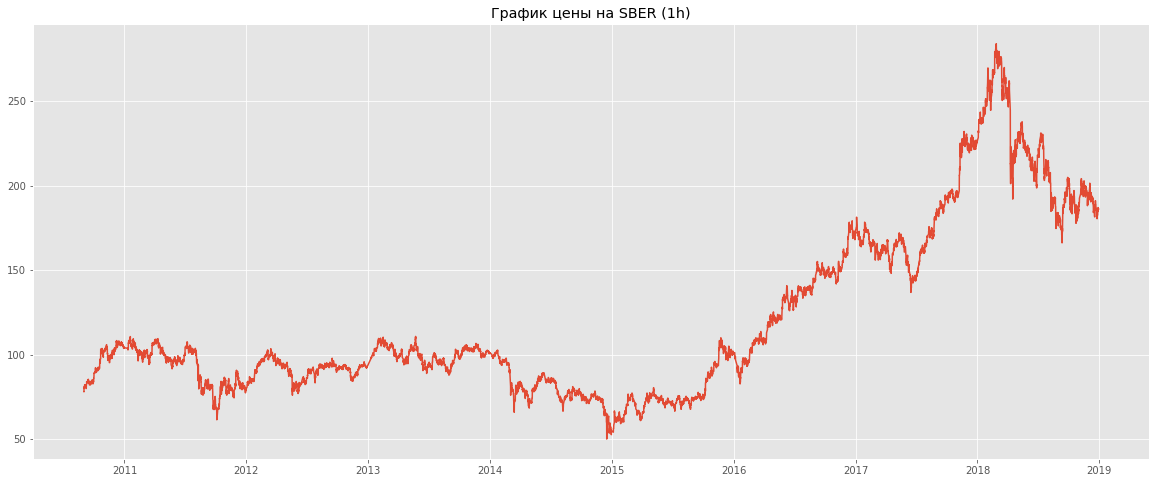

In [ ]:
# Отображение временного ряда в графическом виде
plt.figure(figsize=(20, 8))
plt.plot(data.index, data[COL_CLOSE])
plt.title('График цены на SBER (1h)')
plt.show()

Зададим гиперпараметры

In [ ]:
# Задание гиперпараметров
INDICATOR_DEPTH = 14                      # Глубина расчета индикаторов тренда (шаги)
SEQ_LEN = 19                              # Длина серии (подпоследовательности) входных данных для анализа
PREDICT_LAG = 1                           # Количество шагов в будущее для предсказания
TEST_LEN = 600                            # Объем тестовой выборки (в конце данных)
CLASS_LABELS = ['Нисходящий/боковой', 
                'Восходящий']             # Метки классов: 0-нисходящий/боковой тренд, 1-восходящий тренд

In [ ]:
# Расчет индикаторов относительной доходности
for i in range(1, INDICATOR_DEPTH + 1):
    indicator_change = f'Close_chng_{i}'
    # Относительная доходность в сотых долях за период i шагов назад
    data[indicator_change] = data[COL_CLOSE].pct_change(i)

In [ ]:
# Удаление строк с неполными данными
data.dropna(inplace=True)

In [ ]:
# Вычисление индикаторов направления тренда
for i in range(1, INDICATOR_DEPTH + 1):
    indicator_change = f'Close_chng_{i}'
    indicator_trend = f'Y_{i}'
    # Заполнение столбца индикатора тренда нулями (нисходящий/боковой тренд)
    data[indicator_trend] = 0.
    # Если индикатор изменения периода на i шагов положителен, то тренд восходящий
    data.loc[data[indicator_change] > 0. , indicator_trend] = 1.

In [ ]:
# Формируем x_data
x_col = [COL_CLOSE] + [f'Y_{i}' for i in range(1, INDICATOR_DEPTH + 1)]
x_data = data[x_col].values

# Проверка результата
print(x_data.shape, type(x_data))

(18804, 15) <class 'numpy.ndarray'>


In [ ]:
# Формируем y_data
indicator_name = f'Y_{INDICATOR_DEPTH}'
y_class = data[indicator_name]

# Кодирование признака класса в one hot encoding
y_data = to_categorical(y_class)

# Проверка результата
print(y_data.shape)

(18804, 2)


Формируем выборки

In [ ]:
x_train_data, y_train_data = x_data[:-TEST_LEN-SEQ_LEN], y_data[:-TEST_LEN-SEQ_LEN]
x_test_data, y_test_data = x_data[-TEST_LEN:], y_data[-TEST_LEN:]

# Проверка результата
print('train_data: ', x_train_data.shape, y_train_data.shape,
      '\ntest_data:  ', x_test_data.shape, y_test_data.shape,
      '\nОбщая длина:', x_train_data.shape[0] + x_test_data.shape[0])

train_data:  (18185, 15) (18185, 2) 
test_data:   (600, 15) (600, 2) 
Общая длина: 18785


Масштабируем:

In [ ]:
x_scaler = StandardScaler()
x_scaler.fit(x_train_data)
x_train_data = x_scaler.transform(x_train_data)
x_test_data = x_scaler.transform(x_test_data)

# Проверка результата
print(x_train_data.shape, x_test_data.shape, type(x_train_data))
x_test_data[-1:]

(18185, 15) (600, 15) <class 'numpy.ndarray'>


array([[ 1.40650193,  1.00247764,  0.99271283,  0.99522723,  0.99053149,
         0.98401555,  0.9820689 ,  0.97678842, -1.02331264, -1.02353787,
        -1.02286232,  0.97904815,  0.97431919, -1.02952561, -1.02794036]])

Формируем x_train и y_train

In [ ]:
# Функция разделения набора данных на выборки для обучения нейросети 
# x_data - набор входных данных
# y_data - набор выходных данных
# seq_len - длина серии (подпоследовательности) входных данных для анализа
# predict_lag - количество шагов в будущее для предсказания
def split_sequence(x_data, y_data, seq_len, predict_lag):
    # Определение максимального индекса начала подпоследовательности
    x_len = x_data.shape[0] - seq_len - (predict_lag - 1)
    # Формирование подпоследовательностей входных данных
    x = [x_data[i:i + seq_len] for i in range(x_len)]
    # Формирование меток выходных данных, 
    # отстоящих на predict_lag шагов после конца подпоследовательности
    y = [y_data[i + seq_len + predict_lag - 1] for i in range(x_len)]
    # Возврат результатов в виде массивов numpy
    return np.array(x), np.array(y)

In [ ]:
# Формирование выборок для обучения нейросети
x_train, y_train = split_sequence(x_train_data, y_train_data, SEQ_LEN, PREDICT_LAG)
x_test, y_test = split_sequence(x_test_data, y_test_data, SEQ_LEN, PREDICT_LAG)

# Проверка результата
print('Массивы x_train и y_train:\t', x_train.shape, y_train.shape)
print('Массивы x_test и y_test:\t', x_test.shape, y_test.shape)

Массивы x_train и y_train:	 (18166, 19, 15) (18166, 2)
Массивы x_test и y_test:	 (581, 19, 15) (581, 2)


<h1><b> Генетика </h1>

In [ ]:
#Создаём сеть (net - список параметров)
def create_randnet(net,
                   control_level_shape = 10**5):
  '''
  Функция формирования линейной нейронной ссети из бота.
  
  -----------------
  Входные данные:
  net - полученный бот со списком значений для формирования сети
  control_level_shape - парамметр при превышению которого будет применен 
  слой GlobalAveragePooling1D, а не Flatten (по умолчанию 100'000).
  -----------------
  На выходе функции:
  model -линейная нейронная сеть Sequential()
  '''

  model = Sequential()             # Создаем моель Sequential

  '''
  Присвоение значений параметрам слоев из значений полученного бота
 
  Входной блок
  '''
  makeFirstNormalization = net[0]  # Делаем ли нормализацию в начале
  firstConvSize = 2 ** net[1]      # Размер первого вёрточного слоя
  firstConvKernel = net[2]         # Ядро первого свёрточного слоя
  activation0 = net[3]             # Функция активации входного слоя
  makeMaxPooling0 = net[4]         # Делаем ли maxpooling для нулевого слоя
  maxPoolingSize0 = net[5]         # Размер MaxPooling

  '''
  Первый скрытый Conv блок
  '''
  makeSecondConv = net[6]          # Делаем ли второй свёрточный слой
  secondConvSize = 2 ** net[7]     # Размер второго свёрточного слоя
  secondConvKernel = net[8]        # Ядро второго свёрточного слоя
  makeMaxPooling1 = net[9]         # Делаем ли MaxPooling
  maxPoolingSize1 = net[10]        # Размер MaxPooling
  activation1 = net[11]            # Функция активации

  '''
  Второй скрытый Conv блок
  '''
  makeThirdConv = net[12]          # Делаем ли второй свёрточный слой
  thirdConvSize = 2 ** net[13]     # Размер второго свёрточного слоя
  thirdConvKernel = net[14]        # Ядро второго свёрточного слоя
  makeMaxPooling2 = net[15]        # Делаем ли MaxPooling
  maxPoolingSize2 = net[16]        # Размер MaxPooling
  activation2 = net[17]            # Функция активации

  '''
  Третий скрытый dense блок
  '''
  makeDense = net[18]              # Делаем ли Dense до Flatten 
  denseSize0 = 2 ** net[19]        # Размер полносвязного слоя 
  activationdense0 = net[20]       # Функция активации

  '''
  Выходной dense блок
  '''
  denseSize1 = 2 ** net[21]        # Размер предпоследнего полносвязного слоя 
  activationdense1 = net[22]       # Функция активации предпоследнего полносвязного слоя 
  makeSecondNormalization = net[23]  # Делаем ли нормализацию в начале
  activationdense2 = net[24]       # Функция активации дпоследнего полносвязного слоя 

  '''
  Список активационных функций
  '''
  activation_list = ['linear','relu', 'elu', 'selu' ,'tanh'] 


  '''
  Условия для формирования блоков
  _______________________________

  Входной Conv блок
  '''
  # Если делаем нормализацию в начале
  if (makeFirstNormalization):      
      # Добавляем слой BatchNormalization
      model.add(BatchNormalization(input_shape=(SEQ_LEN, INDICATOR_DEPTH+1))) 

      # Добавляем Conv1D-слой с firstConvSize нейронами и ядром (firstConvKernel)
      model.add(Conv1D(firstConvSize, firstConvKernel,
      activation=activation_list[activation0], padding='same')) 

  else:
      # Добавляем Conv1D-слой с firstConvSize нейронами и ядром (firstConvKernel)
      model.add(Conv1D(firstConvSize, firstConvKernel, input_shape=(SEQ_LEN, INDICATOR_DEPTH+1),
                      activation=activation_list[activation0], padding='same')) 
      # Если делаем maxpooling
  if makeMaxPooling0:               
      model.add(MaxPooling1D(maxPoolingSize0))

  '''
  Первый скрытый Conv блок
  '''
  # Если делаем второй свёрточный слой
  if (makeSecondConv):              
      # Добавляем Conv1D-слой с secondConvSize нейронами и ядром (secondConvKernel)
      model.add(Conv1D(secondConvSize, secondConvKernel,
                      activation=activation_list[activation1], padding='same')) 
      
      # Если делаем MaxPooling
      if (makeMaxPooling1):           
        # Добавляем слой MaxPooling1D с размером (maxPoolingSize)
        model.add(MaxPooling1D(pool_size=maxPoolingSize1)) 

  '''
  Второй скрытый Conv блок
  '''
  # Если делаем второй свёрточный слой
  if (makeThirdConv):               
      # Добавляем Conv1D-слой с secondConvSize нейронами и ядром (secondConvKernel)
      model.add(Conv1D(thirdConvSize, thirdConvKernel,
                      activation=activation_list[activation2], padding='same')) 
      # Если делаем MaxPooling
      if (makeMaxPooling2):           
          # Добавляем слой MaxPooling1D с размером (maxPoolingSize, maxPoolingSize)
          model.add(MaxPooling1D(pool_size=maxPoolingSize2)) 

  '''
  Третий скрытый dense блок
  '''
  # Если делаем Dense до Flatten() или GlobalAveragePooling1D()
  if (makeDense):
      model.add(Dense(denseSize0, activation=activation_list[activationdense0]))

  '''
  Блок проверки размерности слоя
  Для применения Flatten() или GlobalAveragePooling1D()
  для вытягивания в вектор значений и передачи в выходной блок из Dense слоев
  '''
  # Получаем размерность последнего из добавленных слоев
  control_shape = model.layers[-1].output.get_shape()

  # Сравниваем с контрольным значением и применяем слой по условию
  if control_shape[-1]*control_shape[-2] < control_level_shape:
      model.add(Flatten())                   # Добавляем слой Flatten
  else: model.add(GlobalAveragePooling1D())  # Добавляем слой GlobalAveragePooling1D
 
  '''
  Выходной dense блок
  '''
  # Если делаем финальную нормализацию         
  if (makeSecondNormalization):     
      model.add(BatchNormalization()) # Добавляем слой BatchNormalization
  # Добавляем слой Dense с denseSize нейронами  
  model.add(Dense(denseSize1, activation=activation_list[activationdense1])) 
  # Добавляем Dense-слой с softmax-активацией и 10 нейронами
  model.add(Dense(len(CLASS_LABELS), activation=activation_list[activationdense2]))   
  
  # Возвращаем модель
  return model    

In [ ]:
def create_bot4net():
  '''
  Функция создания списка случайных параметров - бота

  -----------------
  Входные данные:
  отсутствуют
  -----------------
  На выходе функции:
  net - список параметров для нелинейной нс
  '''
  net = []
  '''
  Гены входного блока Conv
  '''
  net.append(random.randint(0,1)) # 0 Делаем или нет нормализацию 
  net.append(random.randint(3,10)) # 1 Первый свёрточный слой от 4 до 1024 
  net.append(random.randint(2,5)) # 2 Ядро первого свёрточного слоя от 2 до 7
  net.append(random.randint(0,4)) # 3 Функция активации первого слоя
  net.append(random.randint(0,1)) # 4 Делаем ли MaxPooling
  net.append(random.randint(1,4)) # 5 Размер MaxPooling

  '''
  Гены первого скрытого Conv блока
  '''
  net.append(random.randint(0,1)) # 6 Сколько делаем еще сверточных слоев
  net.append(random.randint(3,10)) # 1 Первый свёрточный слой от 4 до 1024 
  net.append(random.randint(2,5)) # 8 Ядро второго свёрточного слоя от 2 до 8
  net.append(random.randint(0,1)) # 9 Делаем ли MaxPooling
  net.append(random.randint(1,4)) # 10 Размер MaxPooling
  net.append(random.randint(0,4)) # 11 Функция активации второго слоя

  '''
  Гены второого скрытого Conv блока
  '''
  net.append(random.randint(0,1)) # 12 Сколько делаем еще сверточных слоев
  net.append(random.randint(3,10)) # 1 Первый свёрточный слой от 4 до 1024 
  net.append(random.randint(2,5)) # 14 Ядро второго свёрточного слоя от 2 до 8
  net.append(random.randint(0,1)) # 14 Делаем ли MaxPooling
  net.append(random.randint(1,4)) # 16 Размер MaxPooling
  net.append(random.randint(0,4)) # 17 Функция активации второго слоя

  '''
  Гены третьего скрытого dense блока
  '''
  net.append(random.randint(0,1)) # 18 Делаем ли Dense до Flatten 
  net.append(random.randint(2,10)) # 19 Размер полносвязного слоя 
  net.append(random.randint(0,4)) # 20 Функция активации

  '''
  Гены выходного dense блока
  '''
  net.append(random.randint(2,10)) # 21 Размер полносвязного слоя от 4 до 1024
  net.append(random.randint(0,4)) # 22 Функция активации предпоследнего dense слоя
  net.append(random.randint(0,1)) # 23 Делаем ли финальную нормализацию слой
  net.append(random.randint(0,4)) # 24 Функция активации последнего слоя
  
  return net

In [ ]:
bot = create_bot4net()
print(bot)
print('Длина бота', len(bot))
# Создаем модель createConvNet
model = create_randnet(bot)
# выводим слои модели 
model.summary()                               

[0, 7, 4, 4, 0, 3, 1, 6, 4, 1, 2, 2, 0, 8, 3, 1, 1, 1, 0, 4, 4, 8, 0, 0, 3]
Длина бота 25
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 19, 128)           7808      
                                                                 
 conv1d_1 (Conv1D)           (None, 19, 64)            32832     
                                                                 
 max_pooling1d (MaxPooling1D  (None, 9, 64)            0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 576)               0         
                                                                 
 dense (Dense)               (None, 256)               147712    
                                                                 
 dense_1 (Dense)             (No

In [ ]:
def eval_net(net,
             ep,
             verb,
             x_train,
             y_train,
             x_test,
             y_test,
             ):
  '''
  Функция вычисления результатов работы сети:
  
  -----------------
  Входные данные:
  net - бот популяции;
  ep - к-во эпох проверки нс;
  verb - выводить или нет процесс обучения нс на эпохе;
  xData - тренировочные данные;
  yData - проверочные данные;
  x_test - x тестовая выборка;
  y_test - y тестовая выборка;
  ------------------------
  На выходе функции:
  val - на выходе функции оценка работы нс на эпохах проверки
  '''
  val = 0
  model = create_randnet(net) # Создаем модель createConvNet
  scores = []
  # Компилируем модель
  model.compile(loss='binary_crossentropy',
                      metrics=['accuracy'],
                      optimizer='adam')
  print('Обучение модели бота', net)
  history = model.fit(x_train,
                        y_train,
                        epochs=ep, 
                        verbose=verb,
                        validation_split = 0.2,
                        shuffle = False)
        
  val = model.evaluate(x_test, y_test, verbose = 0) [1]  
  return val                      # Возвращаем точность

In [ ]:
eval_net(bot,            # бот популяции 
            10,              # к-во эпох проверки 
            1,              # выводить или нет процесс обучения 
            x_train,  # тренировочные данные
            y_train,    # проверочные данные
            x_test,         # тестовая выборка
            y_test,         # тестовая выборка
            )

Обучение модели бота [0, 10, 2, 4, 0, 3, 1, 9, 3, 0, 1, 2, 1, 10, 5, 1, 1, 4, 0, 9, 0, 6, 2, 1, 2]
Epoch 1/10
455/455 [==============================] - 13s 27ms/step - loss: 3.4963 - accuracy: 0.7578 - val_loss: 5.2156 - val_accuracy: 0.6070
Epoch 2/10
455/455 [==============================] - 12s 26ms/step - loss: 3.8648 - accuracy: 0.7459 - val_loss: 3.1186 - val_accuracy: 0.7933
Epoch 3/10
455/455 [==============================] - 11s 25ms/step - loss: 3.0555 - accuracy: 0.8137 - val_loss: 2.8485 - val_accuracy: 0.8143
Epoch 4/10
455/455 [==============================] - 12s 26ms/step - loss: 2.2047 - accuracy: 0.8543 - val_loss: 2.0993 - val_accuracy: 0.8635
Epoch 5/10
455/455 [==============================] - 12s 26ms/step - loss: 2.1618 - accuracy: 0.8532 - val_loss: 2.1628 - val_accuracy: 0.8586
Epoch 6/10
455/455 [==============================] - 12s 26ms/step - loss: 2.1587 - accuracy: 0.8577 - val_loss: 2.0608 - val_accuracy: 0.8663
Epoch 7/10
455/455 [=================

0.8846815824508667

Подбор гиперпараметров генетикой

In [ ]:
'''
Основные параметры для поиска
'''
n = 15              # Общее число ботов
nsurv = 5           # Количество выживших (столько лучших переходит в новую популяцию)
nnew = n - nsurv    # Количество новых (столько новых ботов создается)
l = 25              # Размер бота
epohs = 20          # количество эпох поиска
control_std = 0.001 # выход из поиска если изменение в лучших ниже данного значения


'''
Изменении показателя мутации по эпохам поиска
'''
mut = 0.5        # коэфициент мутаций
eph_change_mut = [2, 4, 6, 8] # эпохи смены коэфициента мутации
new_mut = [0.4, 0.3, 0.2, 0.1] # новый коэфициент мутаци


'''
Создаём популяцию случайных ботов
'''
popul = []         # Массив популяции
val = []           # Одномерный массив значений этих ботов
for i in range(n):
    popul.append(create_bot4net())


'''
Основной цикл поиска
'''  
sval_best = []    # Одномерный массив значений лучших ботов на эпохах
# Пробегаем по всем эпохам
for it in range(epohs):                 
    # проверяем текущую эпоху it на принадлежность графику смены мутации
    if it in eph_change_mut:
        idx = eph_change_mut.index(it) # получаем индекс  по эпохе
        mut = new_mut[idx] # проверяем текущую эпохуобновляем мутацию
        print('Смена мутации на', mut)
        print()  

    val = []                              # Обнуляем значения бота
    curr_time = time.time()               # засекаем время

    '''
    Получение оценок ботов
    '''  
    # Пробегаем в цикле по всем ботам 
    for i in range(n):                    
        bot = popul[i]                     # Берем очередного бота

        # Вычисляем точность текущего бота
        f = eval_net(bot,            # бот популяции 
                    6,              # к-во эпох проверки 
                    0,              # выводить или нет процесс обучения 
                    x_train,  # тренировочные данные
                    y_train,    # проверочные данные
                    x_test,         # тестовая выборка
                    y_test,         # тестовая выборка
                    ) 
        val.append(f)   # Добавляем полученное значение в список val
    
    '''
    Сортировка оценок ботов и контроль поиса
    ''' 
    sval = sorted(val, reverse=1)         # Сортируем val
    # Выводим 5 лучших ботов
    print(it, time.time() - curr_time, " ", sval[0:5],popul[:5]) 

    sval_best.append(sval[0])             # добавляем значение лучшего бота
    # проверка на продолжение поиска, есть разница или уже нет в точности
    if it > 5:                            # с 6й эпохи 
        sval_best = sorted(sval_best, reverse=0)[:5] # сортируем и берем 5ть лучших 
        if np.std(sval_best) < control_std:          # сверяем значения на отличие 
            print('Поиск дучших не дает нового, выход')
            break

    '''
    Сохранение лучших ботов в newpopul
    '''  
    newpopul = [] # Создаем пустой список под новую популяцию
    # Пробегаем по всем выжившим ботам
    for i in range(nsurv):
        # Получаем индекс очередного бота из списка лучших в списке val             
        index = val.index(sval[i])
        # Добавляем в новую популяцию бота из popul с индексом index        
        newpopul.append(popul[index])       
    '''
    Создание новых ботов на основе лучших ботов в newpopul.
    Иногда дополнительно применение мутации
    '''
    # Проходимся в цикле nnew-раз 
    for i in range(nnew):
        # случайный выбор родителя в диапазоне от 0 до nsurv - 1              
        indexp1 = random.randint(0,nsurv-1) # Случайный индекс 1го родителя 
        indexp2 = random.randint(0,nsurv-1) # Случайный индекс 1го родителя
        botp1 = newpopul[indexp1]           # бота-родителя 1 по indexp1
        botp2 = newpopul[indexp2]           # бота-родителя  2 по indexp2    
        newbot = []                         # пустой список для нового бота    
        net4Mut = create_bot4net()         # Создаем случайную сеть для мутаций

        '''
        Пробегаем по всей длине бота
        '''
        for j in range(l):                        
            x = 0      

            '''
            Скрещмивание
            '''
            # Получаем случайное число в диапазоне от 0 до 1
            pindex = random.random() 
            # Если pindex меньше 0.5, то берем значения от 1 бота, иначе от 2
            if pindex < 0.5:
                x = botp1[j]
            else:
                x = botp2[j]
            
            '''
            Мутация
            '''
            # С вероятностью mut устанавливаем значение бота из net4Mut
            if (random.random() < mut):
                x = net4Mut[j]
              
            newbot.append(x)    # Добавляем очередное значение в нового бота      
        newpopul.append(newbot) # Добавляем бота в новую популяцию      
    popul = newpopul            # Записываем в popul новую посчитанную популяцию

Обучение модели бота [0, 5, 5, 3, 0, 2, 0, 10, 3, 1, 4, 4, 1, 7, 2, 1, 4, 2, 1, 3, 2, 8, 1, 0, 3]
Обучение модели бота [0, 4, 4, 1, 0, 4, 0, 3, 2, 0, 1, 0, 0, 5, 3, 0, 1, 0, 1, 9, 4, 3, 3, 1, 0]
Обучение модели бота [1, 8, 3, 3, 1, 4, 0, 3, 5, 1, 3, 3, 1, 4, 3, 1, 3, 0, 1, 9, 3, 3, 0, 1, 2]
Обучение модели бота [0, 3, 3, 4, 1, 2, 1, 4, 4, 0, 1, 4, 1, 8, 2, 0, 1, 3, 0, 6, 0, 7, 0, 0, 4]
Обучение модели бота [0, 9, 4, 2, 0, 2, 0, 3, 3, 0, 3, 1, 0, 6, 3, 0, 3, 2, 0, 4, 2, 9, 3, 0, 4]
Обучение модели бота [1, 3, 2, 1, 0, 2, 1, 4, 5, 1, 3, 0, 0, 4, 4, 1, 2, 3, 1, 4, 1, 9, 4, 0, 3]
Обучение модели бота [0, 4, 5, 1, 1, 3, 1, 10, 4, 0, 3, 3, 0, 3, 5, 1, 4, 1, 0, 9, 3, 6, 0, 1, 3]
Обучение модели бота [0, 3, 3, 0, 0, 4, 1, 3, 3, 0, 2, 4, 0, 10, 4, 0, 3, 2, 0, 9, 2, 7, 3, 0, 0]
Обучение модели бота [0, 4, 2, 4, 0, 1, 0, 8, 2, 1, 1, 3, 0, 5, 2, 0, 1, 2, 1, 2, 1, 2, 3, 0, 4]
Обучение модели бота [1, 10, 5, 4, 1, 4, 0, 9, 5, 0, 1, 3, 1, 6, 5, 1, 3, 1, 0, 9, 1, 8, 3, 1, 2]
Обучение модели бота [0, 6

In [ ]:
# Выведем 4 лучших бота
for bot in popul[:4]: 
    print(bot) #Геномы лучших ботов по эпохам

[0, 4, 5, 3, 0, 2, 0, 7, 3, 1, 2, 2, 1, 7, 4, 0, 2, 1, 0, 4, 2, 3, 4, 0, 4]
[0, 4, 5, 3, 0, 2, 0, 7, 3, 1, 2, 3, 1, 7, 4, 0, 2, 1, 0, 4, 2, 3, 4, 0, 4]
[0, 4, 5, 3, 0, 2, 0, 7, 3, 1, 2, 3, 1, 7, 4, 0, 2, 1, 0, 4, 2, 3, 4, 0, 4]
[0, 4, 5, 3, 0, 2, 0, 7, 3, 1, 2, 2, 1, 7, 4, 0, 2, 1, 0, 4, 2, 3, 4, 0, 4]


In [ ]:
#Дообучим лучший бот
bot = popul[0]
print(bot)

model_1 = create_randnet(bot)
model_1.summary()

[0, 4, 5, 3, 0, 2, 0, 7, 3, 1, 2, 2, 1, 7, 4, 0, 2, 1, 0, 4, 2, 3, 4, 0, 4]
Model: "sequential_490"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_1071 (Conv1D)        (None, 19, 16)            1216      
                                                                 
 conv1d_1072 (Conv1D)        (None, 19, 128)           8320      
                                                                 
 flatten_490 (Flatten)       (None, 2432)              0         
                                                                 
 dense_1152 (Dense)          (None, 8)                 19464     
                                                                 
 dense_1153 (Dense)          (None, 2)                 18        
                                                                 
Total params: 29,018
Trainable params: 29,018
Non-trainable params: 0
______________________________________

In [ ]:
epoch_list = [(7, Adam(learning_rate=1e-4)),
              (10, Adam(learning_rate=1e-5)),
              (10, Adam(learning_rate=1e-6)),
              (13, Adam(learning_rate=1e-7)),
              ]
epochs = 0
for elem in epoch_list: epochs += elem[0] 

val_accuracy = []
accuracy= []
#Комипилируем и обучаем
for epoch_lr, opt in epoch_list:
    model_1.compile(optimizer='adam',
                    loss='binary_crossentropy',
                    metrics=['accuracy'])
    history = model_1.fit(x_train,
                          y_train,
                        epochs=epoch_lr, 
                        validation_data=(x_test, y_test))
    val_accuracy.extend(history.history['val_accuracy'])
    accuracy.extend(history.history['accuracy'])
    
results = {'accuracy':accuracy, '\nval_accuracy':val_accuracy}


Epoch 1/7
568/568 [==============================] - 7s 10ms/step - loss: 0.3525 - accuracy: 0.9086 - val_loss: 0.2991 - val_accuracy: 0.9294
Epoch 2/7
568/568 [==============================] - 5s 8ms/step - loss: 0.2984 - accuracy: 0.9082 - val_loss: 0.1707 - val_accuracy: 0.9535
Epoch 3/7
568/568 [==============================] - 5s 9ms/step - loss: 0.2273 - accuracy: 0.9255 - val_loss: 0.1638 - val_accuracy: 0.9501
Epoch 4/7
568/568 [==============================] - 5s 9ms/step - loss: 0.2529 - accuracy: 0.9192 - val_loss: 0.1941 - val_accuracy: 0.9518
Epoch 5/7
568/568 [==============================] - 5s 9ms/step - loss: 0.2299 - accuracy: 0.9280 - val_loss: 0.1633 - val_accuracy: 0.9552
Epoch 6/7
568/568 [==============================] - 4s 8ms/step - loss: 0.2166 - accuracy: 0.9297 - val_loss: 0.1725 - val_accuracy: 0.9449
Epoch 7/7
568/568 [==============================] - 3s 5ms/step - loss: 0.2139 - accuracy: 0.9304 - val_loss: 0.1769 - val_accuracy: 0.9466
Epoch 1/10
5

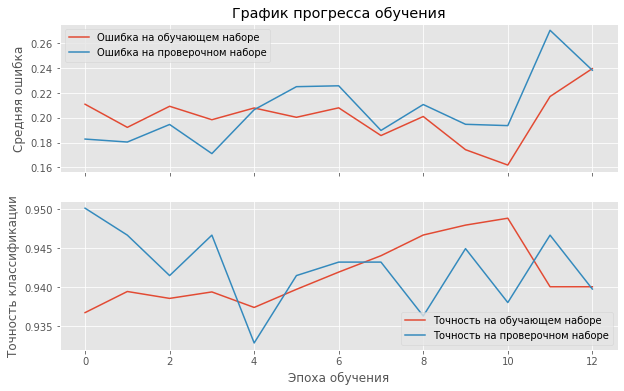

In [ ]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 6), sharex=True)
ax1.set_title(f'График прогресса обучения')
ax1.plot(history.history['loss'], label='Ошибка на обучающем наборе')
ax1.plot(history.history['val_loss'], label='Ошибка на проверочном наборе')
ax1.set_ylabel('Средняя ошибка')
ax1.legend()

ax2.plot(history.history['accuracy'], label='Точность на обучающем наборе')
ax2.plot(history.history['val_accuracy'], label='Точность на проверочном наборе')
ax2.set_ylabel('Точность классификации')
ax2.legend()

# Указание показывать только целые метки шкалы оси x
fig.gca().xaxis.get_major_locator().set_params(integer=True)
plt.xlabel('Эпоха обучения')
plt.show()

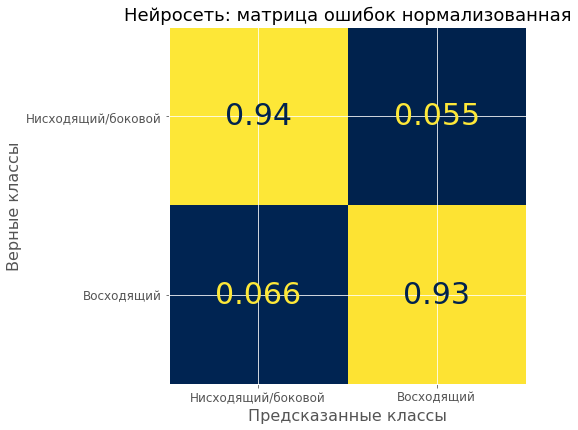

In [ ]:
# Вычисление предсказания сети
y_pred = model_1.predict(x_test)
# Построение матрицы ошибок
cm = confusion_matrix(np.argmax(y_test, axis=1),
                        np.argmax(y_pred, axis=1),
                        normalize='true')
# Округление значений матрицы ошибок
cm = np.around(cm, 3)

# Задание размера шрифта по умолчанию для текста в клетках матрицы
old_font_size = rcParams['font.size']
rcParams['font.size'] = 30

# Отрисовка матрицы ошибок
fig, ax = plt.subplots(figsize=(8,8))
ax.set_title(f'Нейросеть: матрица ошибок нормализованная', fontsize=18)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=CLASS_LABELS)
disp.plot(ax=ax, cmap='cividis')
ax.images[-1].colorbar.remove()       # Стирание ненужной цветовой шкалы
plt.xticks(fontsize=12)
plt.xlabel('Предсказанные классы', fontsize=16)
plt.yticks(fontsize=12)
plt.ylabel('Верные классы', fontsize=16)
plt.show()  